In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import local_helpers as lh
import pingouin as pg
import math

# Time demand patterns
In this notebook we want to examine how the demand for the bike rentals varies over time.

In [17]:
sns.set_theme(style="darkgrid", rc={'figure.figsize': (9, 5)})

# Global variables
df_boston = lh.load_prepared_data()

## General Overview of rentals per day over complete year


First we will take a general look at the distribution of rides over the year and try to detect trends. Afterwards, we will take a detailed look into the relationship and connection between temperatur and number of rides, as we suspect this might have a strong relation. 

        month  num_rides
0       April      56776
1      August     164744
2    December      52095
3    February       4212
4     January       8111
5        July     178571
6        June     149403
7       March      11605
8         May     152340
9    November      90593
10    October     128130
11  September     153095


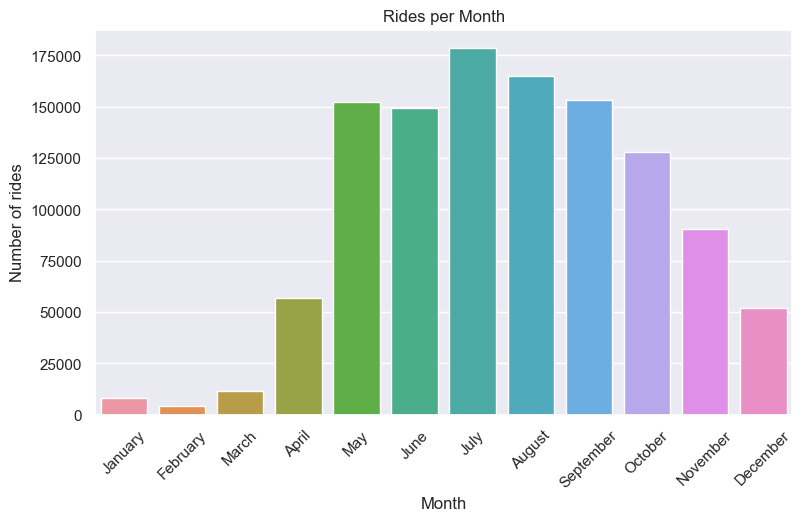

<Figure size 900x500 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

df_rentals_total = df_boston.copy()
df_rentals_total['month'] = df_rentals_total['end_time'].dt.month_name()
df_rentals_total_month = df_rentals_total.groupby(['month']).size().reset_index(name='num_rides')
df_rentals_total_month['month'] = pd.Categorical(df_rentals_total_month['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

ax1 = sns.barplot(data=df_rentals_total_month, x='month', y='num_rides')


fig = plt.figure()
ax1.set(xlabel='Month', ylabel='Number of rides', title='Rides per Month')
ax1.set_ylabel('Number of rides')
ax1.tick_params(axis='x', rotation=45)

print(df_rentals_total_month[['month', 'num_rides']])

In the graph we can see a significant rise in the number of rides from March to April. This is the effect of a policy of thehubay/bluebikes were they close a number of stations over the winter due to low demand. This effect will be discussed in more detail after first looking into the relationship between temperature and number of rides next.

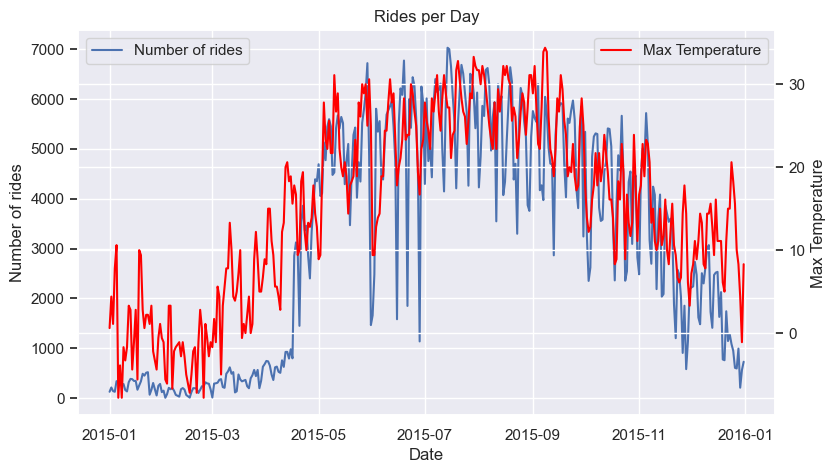

In [19]:
# Data
demand_series = df_boston.groupby(df_boston['start_time'].dt.date).size()
demand_series.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

max_temp_day = df_boston.groupby(df_boston['start_time'].dt.date)
max_temp_day.index = pd.to_datetime(demand_series.index, format='%Y-%m-%d')

# Graph
fig = plt.figure()
ax1 = sns.lineplot(data=demand_series, legend=True)
ax1.set(xlabel='Date', ylabel='Number of rides', title='Rides per Day')
ax1.set_ylabel('Number of rides')
ax1.legend(['Number of rides'], loc="upper left")
ax2 = ax1.twinx()

sns.lineplot(data=max_temp_day['max_temp'].max('max_temp'), ax=ax2, color='red', legend=True)
ax2.set_ylabel('Max Temperature')
ax2.legend(['Max Temperature'], loc="upper right")

In this graph we see all rentals of the year for every day. In addition to that on the second y-axis the maximal temperature of each day is sketched. The max temperature and the number of rentals correlate mostly. An exception is the spring - as discussed previously bluebikes/thehubway closes most of their stations over the months January-March. Even though the temperature rises, the number of rentals therefore only increases slowly, until mid of april, when the rentals grow significantly.

### Analysis of Season-Planning

As Bluebikes/thehubway closes a majority of their stations during the winter due to low demand, the number of rides each month shrinks significantly. The question that arises from this - which is also interesting regarding the management of the system - is if they closed the right stations. In order to determine this, we will try to set up measures that define how well a station is doing in terms of utilization during the summer months and from there extrapolate the most likely demand the station would generate in the winter.

First, we will calculate the utilization of each station for each year of the month. With this, we should be able to clearly identify stations that are closed as their respective utilization should drop to zero.

In [20]:
df_stations_analysis = df_boston.copy()
df_stations_analysis['month'] = df_stations_analysis['start_time'].dt.month_name()
df_stations_analysis['month'] = pd.Categorical(df_stations_analysis['month'], categories=['January', 'February', 'March' , 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)

df_stations_analysis['week_num'] = df_stations_analysis['start_time'].dt.isocalendar().week

# Traffic = number of arrivals/departures from the respective staion
start_station_traffic_per_kw = df_stations_analysis.groupby(['start_station_name', 'week_num']).size().unstack(fill_value=0).stack().to_frame(name='inbound_traffic_sum')
start_station_traffic_per_kw.reset_index(inplace=True, names=['station_name', 'week_num'])

end_station_traffic_per_kw = df_stations_analysis.groupby(['end_station_name', 'week_num']).size().unstack(fill_value=0).stack().to_frame(name='outbound_traffic_sum')
end_station_traffic_per_kw.reset_index(inplace=True, names=['station_name', 'week_num'])

df_station_traffic_sum_kw = end_station_traffic_per_kw.merge(start_station_traffic_per_kw, on=['station_name', 'week_num']).sort_values(['station_name', 'week_num'])

# Divide by two because otherwise one ride would account for two units of traffic (one inbound, one outbound)
df_station_traffic_sum_kw['total_traffic_sum'] = (df_station_traffic_sum_kw['outbound_traffic_sum'] + df_station_traffic_sum_kw['inbound_traffic_sum'])/2

# During season close, Stations will have a traffic of zero
# This will also include maintenance times. 

df_station_traffic_sum_kw_season = df_station_traffic_sum_kw[df_station_traffic_sum_kw['total_traffic_sum'] != 0]

df_station_traffic_avg_season = df_station_traffic_sum_kw_season.groupby('station_name')['total_traffic_sum'].mean().to_frame(name='weekly_traffic_average_season')

df_station_traffic_avg_season.sort_values('weekly_traffic_average_season', ascending=False, inplace=True)

# All stations opened year round are stations in the cambridge district - reintroducing info into the dataset
df_municipality = pd.read_csv('./data/2015_full_system_station_list.csv', sep=';')
df_municipality['municipality'] = df_municipality['MUNICIPALITY']
df_municipality['station_name'] = df_municipality['STATION_NAME']
df_municipality = df_municipality[['station_name', 'municipality']]

df_station_traffic_avg_season = df_station_traffic_avg_season.merge(df_municipality, on='station_name', how='left')

print(df_station_traffic_avg_season.head(15))


                                         station_name  \
0                   South Station - 700 Atlantic Ave.   
1                        MIT at Mass Ave / Amherst St   
2       Charles Circle - Charles St. at Cambridge St.   
3              TD Garden - Causeway at Portal Park #1   
4            Boston Public Library - 700 Boylston St.   
5                                Beacon St / Mass Ave   
6                 Harvard Square at Mass Ave/ Dunster   
7                        Back Bay / South End Station   
8                               Boylston at Fairfield   
9                       Boylston St. at Arlington St.   
10              Central Square at Mass Ave / Essex St   
11                           Cross St. at Hanover St.   
12            MIT Stata Center at Vassar St / Main St   
13  Lafayette Square at Mass Ave / Main St / Colum...   
14                              Kenmore Sq / Comm Ave   

    weekly_traffic_average_season municipality  
0                      842.368421     

[Text(0, 0.5, 'Weekly average traffic')]

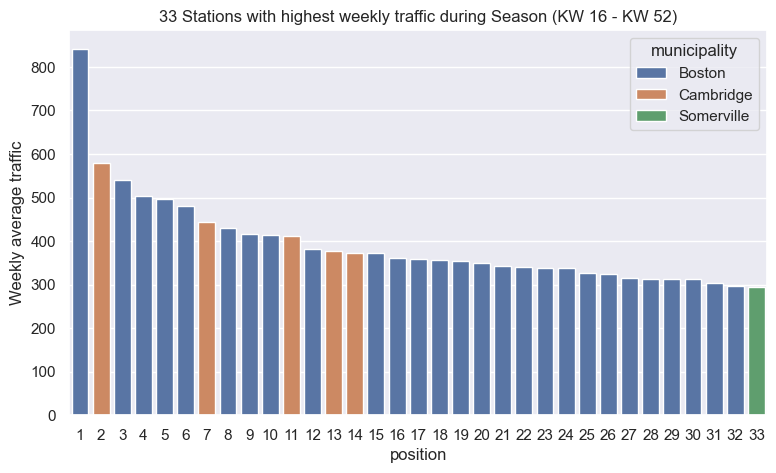

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
df_barchart = df_station_traffic_avg_season.copy()
df_barchart['position'] = df_barchart.index+1

df_barchart.head()

station_count=33

graph = sns.barplot(data=df_barchart.iloc[:station_count,:], y='weekly_traffic_average_season', x='position', hue='municipality', dodge=False)
graph.set(title=f'{station_count} Stations with highest weekly traffic during Season (KW 16 - KW 52)')
graph.set(ylabel='Weekly average traffic')

As we can see from the graph, most of the station with the highest seasonal traffic are not present in the set of stations kept open during the off season (Only cambridge based stations are kept open). Especially surisping about this is that the highest traffic station (South Station) is not kept open during the winter.

Next, we will calculate the change rate of the cambrige stations from summer traffic to winter traffic. With this, we can get a rough estimate for potential traffic at each location. This estimate makes no claim to correctness, as there will be other factors like overlapping between stations or other individual factors like changing schedules of public transport during the winter that might influence the traffic at the respective locations. It does, however, give us a ballpark figure of the traffic we might observe had we kept the stations open during the winter season.

Eren, Ezgi; Uz, Volkan Emre  (2019). A Review on Bike-Sharing: The Factors Affecting Bike-Sharing Demand. Sustainable Cities and Society (Page 13ff)     

In [22]:
# Get the change rate during winter/ summer of cambrige 
# only cambrige based stations in the first 16 weeks
off_season_duration_in_weeks = 15

df_off_season_analysis = df_station_traffic_sum_kw.copy()
df_off_season_analysis = df_off_season_analysis.merge(df_municipality, on='station_name')
df_cambridge_off_season_weekly_traffic = df_off_season_analysis[np.logical_and(df_off_season_analysis['municipality'] == 'Cambridge', df_off_season_analysis['week_num'] <= off_season_duration_in_weeks)]

df_station_traffic_avg_off_season = df_cambridge_off_season_weekly_traffic.groupby('station_name')['total_traffic_sum'].mean().to_frame(name='weekly_traffic_average_off_season')
df_station_traffic_avg_off_season.sort_values('weekly_traffic_average_off_season', ascending=False, inplace=True)


df_season_comparison = df_station_traffic_avg_off_season.merge(df_station_traffic_avg_season, on='station_name')

# remove all fully closed cambridge stations (they are listed but were not open due to construction)
df_season_comparison = df_season_comparison[df_season_comparison['weekly_traffic_average_off_season'] != 0]

df_season_comparison['off_seasons_traffic_change_rate'] = df_season_comparison['weekly_traffic_average_off_season'] / df_season_comparison['weekly_traffic_average_season']

average_off_season_traffic_change = df_season_comparison['off_seasons_traffic_change_rate'].mean()

print(f'Traffic dropped by an average factor {average_off_season_traffic_change} for all {len(df_season_comparison)} cambridge based stations')


Traffic dropped by an average factor 0.29994509988032875 for all 33 cambridge based stations


                                        station_name  \
0                       MIT at Mass Ave / Amherst St   
1                                 Ames St at Main St   
2              Central Square at Mass Ave / Essex St   
3            MIT Stata Center at Vassar St / Main St   
4  Central Sq Post Office / Cambridge City Hall a...   

   weekly_traffic_average_off_season  weekly_traffic_average_season  \
0                         175.033333                     579.160377   
1                         143.400000                     290.783019   
2                         124.133333                     411.632075   
3                         114.233333                     377.283019   
4                         108.600000                     274.632075   

  municipality  off_seasons_traffic_change_rate  station_id  
0    Cambridge                         0.302219           0  
1    Cambridge                         0.493151           1  
2    Cambridge                         0.301564   

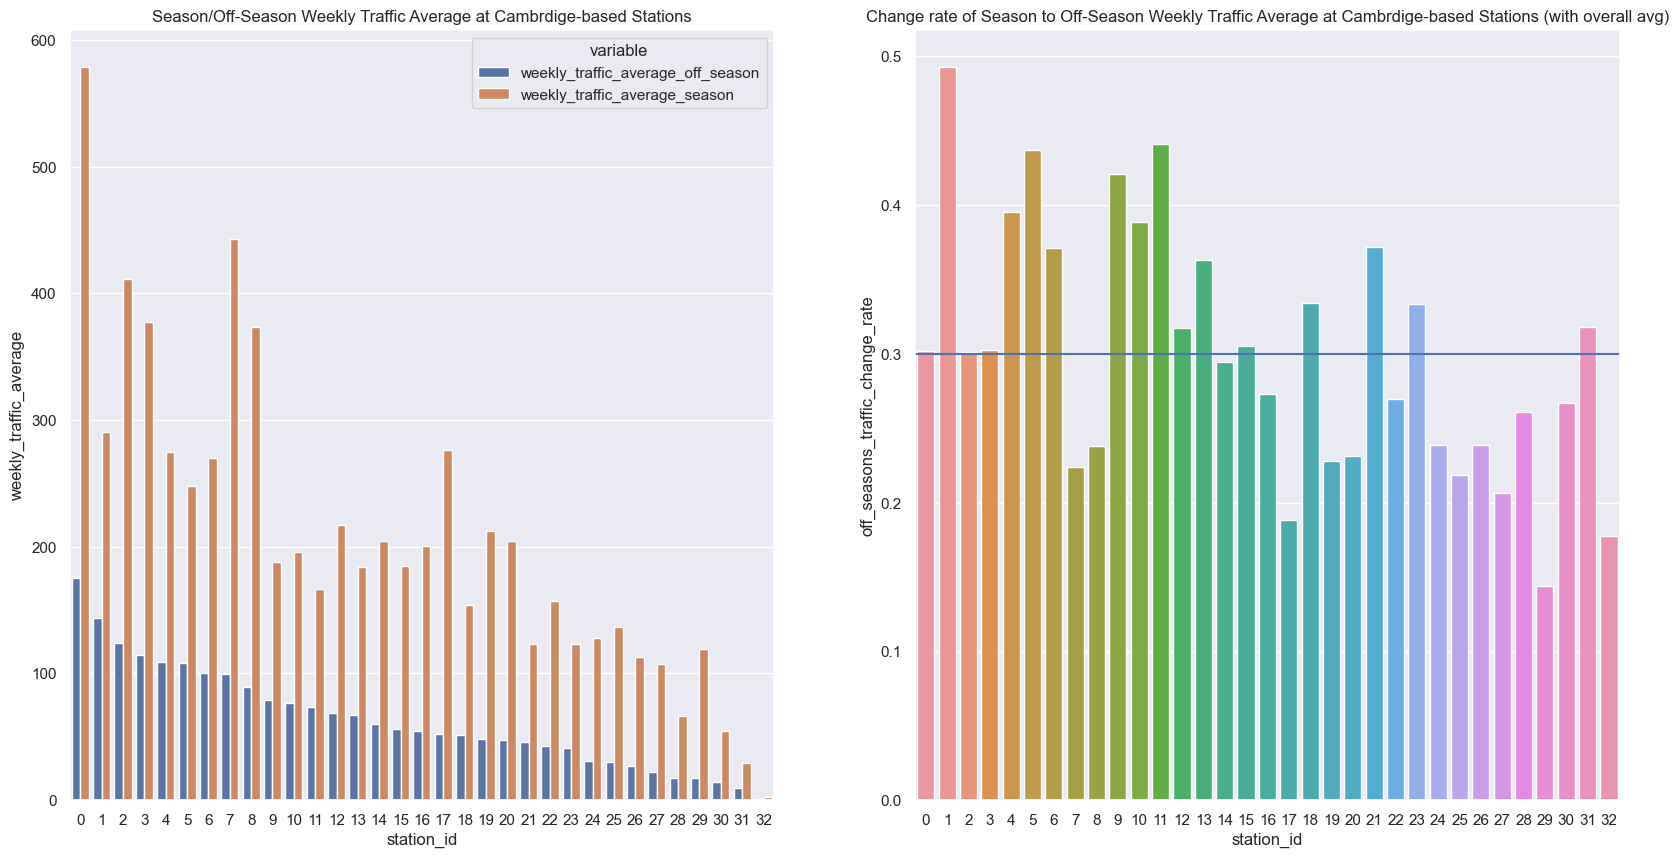

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(20,10))
df_barchart = df_season_comparison.copy()

ids, keys = pd.factorize(df_barchart['station_name'])
df_station_index = pd.DataFrame({'station_id': ids, 'station_name': keys})

df_linechart = df_barchart.copy().merge(df_station_index, on='station_name')
print(df_linechart.head())

graph1 = sns.barplot(data=df_linechart, x='station_id', y='off_seasons_traffic_change_rate', ax=ax[1])
graph1.axhline(df_linechart['off_seasons_traffic_change_rate'].mean())
ax[1].set_title('Change rate of Season to Off-Season Weekly Traffic Average at Cambrdige-based Stations (with overall avg)')

df_barchart = pd.melt(df_barchart, id_vars=['station_name'], value_vars=['weekly_traffic_average_off_season', 'weekly_traffic_average_season'], value_name='weekly_traffic_average')
df_barchart = df_barchart.merge(df_station_index, on='station_name')

graph2 = sns.barplot(data=df_barchart, x='station_id', y='weekly_traffic_average', hue='variable', ax=ax[0])
ax[0].set_title('Season/Off-Season Weekly Traffic Average at Cambrdige-based Stations')

plt.show()

To get from traffic to theoretically generated revenue, we need to estimate the potential revenue through a proxy. Because we have very limited data regarding revenue (no direct user_id to attribute rides to a certain account), we will make another assumption to get a revenue figure: We look at the average rate of customers vs. subscribers for each station and extrapolate the number of additional rides for customers we generated for each station. The reason for this is that new customers mean additional reveneue, while new subscriber rides might also come from existing subscribers.   

In [24]:
# Additional KPI - customer based revenue

df_stations_analysis_revenue = df_boston.copy()

df_start_stations_analysis_revenue = df_stations_analysis_revenue.groupby("start_station_name")["user_type"].value_counts().unstack().rename(columns={'Customer':'yearly_customer_count', 'Subscriber':'yearly_subscriber_count'}).fillna(0)
df_start_stations_analysis_revenue.reset_index(inplace=True, names=['station_name', 'user_type'])

df_end_stations_analysis_revenue = df_stations_analysis_revenue.groupby("end_station_name")["user_type"].value_counts().unstack().rename(columns={'Customer':'yearly_customer_count', 'Subscriber':'yearly_subscriber_count'}).fillna(0)
df_end_stations_analysis_revenue.reset_index(inplace=True, names=['station_name', 'user_type'])


df_start_stations_analysis_revenue['yearly_customer_count'] = df_end_stations_analysis_revenue['yearly_customer_count']
df_start_stations_analysis_revenue['yearly_subscriber_count'] = df_end_stations_analysis_revenue['yearly_subscriber_count']
df_all_stations_analysis_revenue = df_start_stations_analysis_revenue


df_all_stations_analysis_revenue['customer_percentage'] = df_all_stations_analysis_revenue['yearly_customer_count'] /  (df_all_stations_analysis_revenue['yearly_subscriber_count'] + df_all_stations_analysis_revenue['yearly_customer_count'])
df_all_stations_analysis_revenue['subscriber_percentage'] = df_all_stations_analysis_revenue['yearly_subscriber_count'] /  (df_all_stations_analysis_revenue['yearly_subscriber_count'] + df_all_stations_analysis_revenue['yearly_customer_count'])

# Combining the data
df_all_stations_analysis_revenue = df_all_stations_analysis_revenue.merge(df_station_traffic_avg_season, on='station_name')

With all the data in place, we can now calculate the theoretical revenue each closed station generated through its traffic multiplied with the percentage of rides from customers at the respective station. From here, we will rank the station by revenue potential to select the stations that we should keep open during the winter.



In [25]:

# Calculating the potential traffic + revenue

# Model Variables
off_season_duration_in_weeks = off_season_duration_in_weeks
average_one_time_ticket_price = 9
off_season_stations_count= len(df_season_comparison)

df_all_stations_analysis_revenue['potential_traffic_during_off_season'] = df_all_stations_analysis_revenue['weekly_traffic_average_season'] * average_off_season_traffic_change * off_season_duration_in_weeks 

# 9 avg. revenue per customer, assuming a customer completes one ride with his ticket
df_all_stations_analysis_revenue['potential_revenue_during_off_season'] = df_all_stations_analysis_revenue['potential_traffic_during_off_season'] * df_all_stations_analysis_revenue['customer_percentage'] * average_one_time_ticket_price

# List with the revenue Potential
df_all_stations_analysis_revenue = df_all_stations_analysis_revenue.sort_values('potential_revenue_during_off_season', ascending=False)


#Compare to actual revenue
df_actual_off_season_revenue = df_season_comparison.copy()
df_actual_off_season_revenue = df_actual_off_season_revenue.merge(df_all_stations_analysis_revenue[['station_name', 'customer_percentage']], on='station_name')
df_actual_off_season_revenue['real_revenue_during_off_season'] = (df_actual_off_season_revenue['weekly_traffic_average_off_season']*off_season_duration_in_weeks) * df_actual_off_season_revenue['customer_percentage'] * average_one_time_ticket_price

real_revenue_cambridge_stations = float("{:.2f}".format(df_actual_off_season_revenue['real_revenue_during_off_season'].sum()))
potential_revenue_custom_ranking = float("{:.2f}".format(df_all_stations_analysis_revenue.iloc[:off_season_stations_count-1]["potential_revenue_during_off_season"].sum()))

print(f'The first {off_season_stations_count} stations in our ranking could potentially generate a revenue of {potential_revenue_custom_ranking} Dollars from Rides for customers, assuming one ticket is bought per ride')
print(f'The {off_season_stations_count} stations in the Cambridge District generate a revenue of {real_revenue_cambridge_stations} Dollars from Rides for customers, assuming one ticket is bought per ride')
print(f'increase of {potential_revenue_custom_ranking-real_revenue_cambridge_stations} Dollars or {(potential_revenue_custom_ranking/real_revenue_cambridge_stations)-1}% increase')


df_actual_off_season_revenue.head()
#df_all_stations_analysis_revenue.head()




The first 33 stations in our ranking could potentially generate a revenue of 204878.55 Dollars from Rides for customers, assuming one ticket is bought per ride
The 33 stations in the Cambridge District generate a revenue of 66599.43 Dollars from Rides for customers, assuming one ticket is bought per ride
increase of 138279.12 Dollars or 2.076280833034157% increase


,station_name,weekly_traffic_average_off_season,weekly_traffic_average_season,municipality,off_seasons_traffic_change_rate,customer_percentage,real_revenue_during_off_season
0,MIT at Mass Ave / Amherst St,175.033333,579.160377,Cambridge,0.302219,0.109845,2595.580741
1,Ames St at Main St,143.400000,290.783019,Cambridge,0.493151,0.187680,3633.291776
2,Central Square at Mass Ave / Essex St,124.133333,411.632075,Cambridge,0.301564,0.247442,4146.638672
3,MIT Stata Center at Vassar St / Main St,114.233333,377.283019,Cambridge,0.302779,0.159767,2463.842354
4,Central Sq Post Office / Cambridge City Hall a...,108.600000,274.632075,Cambridge,0.395438,0.312483,4581.307756


,station_name,municipality,potential_traffic_during_off_season,potential_revenue_during_off_season
129,South Station - 700 Atlantic Ave.,Boston,3789.964203,17831.234420
134,TD Garden - Causeway at Portal Park #1,Boston,2264.435532,10070.980710
116,Post Office Square,Boston,1591.091589,8798.958025
10,Back Bay / South End Station,Boston,1938.972025,8675.819318
120,Rowes Wharf - Atlantic Ave,Boston,1525.635231,7986.647089
59,Franklin St. / Arch St.,Boston,1528.268662,7971.607218
16,Boston Public Library - 700 Boylston St.,Boston,2229.285715,7435.118584
33,Charles Circle - Charles St. at Cambridge St.,Boston,2428.782013,7143.560333
21,Boylston at Fairfield,Boston,1867.593651,6868.290785
135,TD Garden - Causeway at Portal Park #2,Boston,1542.936340,6742.357913


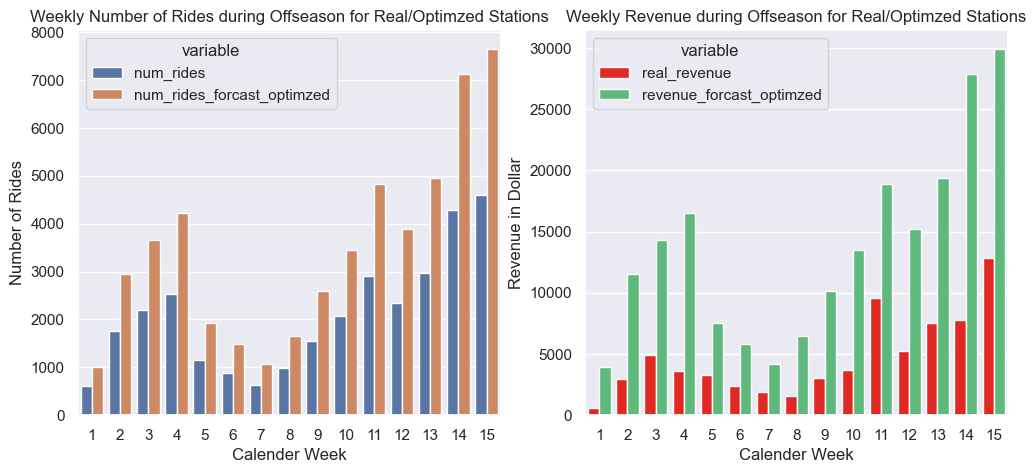

In [51]:
# Plots for increase in traffic
df_rides_count_weeks = df_boston.copy()
fig, ax = plt.subplots(1,2,figsize=(12,5))


df_rides_count_weeks['week_num'] = df_rides_count_weeks['start_time'].dt.isocalendar().week
df_rides_count_weeks = df_rides_count_weeks.groupby(by='week_num').size().reset_index(name='num_rides')
df_rides_count_weeks.sort_values('week_num', inplace=True)



df_rides_count_weeks['average_rides_volume_cambridge'] = df_actual_off_season_revenue['weekly_traffic_average_off_season'].sum()

df_rides_count_weeks_revenue = df_rides_count_weeks.copy()

# Get the first 33 ranked stations (total volume)
df_all_stations_analysis_revenue.sort_values('potential_revenue_during_off_season')
df_rides_count_weeks['average_rides_volume_forcast_optimzed'] = (df_all_stations_analysis_revenue.iloc[:off_season_stations_count-1,:]['weekly_traffic_average_season'] * average_off_season_traffic_change).sum()
optimal_stations = df_all_stations_analysis_revenue.iloc[:off_season_stations_count-1,:]
df_rides_count_weeks['num_rides_forcast_optimzed'] =  (df_rides_count_weeks['num_rides']/df_rides_count_weeks['average_rides_volume_cambridge'])* df_rides_count_weeks['average_rides_volume_forcast_optimzed'] 


df_rides_count_weeks_melted = df_rides_count_weeks.melt(id_vars='week_num', value_vars=['num_rides', 'num_rides_forcast_optimzed'])
df_rides_count_weeks_melted = df_rides_count_weeks_melted.sort_values('week_num')

sns.barplot(data=df_rides_count_weeks_melted.iloc[:(off_season_duration_in_weeks*2),:], x='week_num', y='value', hue='variable', ax=ax[0])
ax[0].set(title='Weekly Number of Rides during Offseason for Real/Optimzed Stations')
ax[0].set(xlabel='Calender Week', ylabel='Number of Rides')

# Plots for increase in revenue (rip)
df_revenue_increase_plot = df_all_stations_analysis_revenue.copy()

df_revenue_increase_plot['weekly_traffic_average_off_season'] = df_revenue_increase_plot['weekly_traffic_average_season'] * average_off_season_traffic_change
df_revenue_increase_plot['weekly_revenue_average_off_season'] = df_revenue_increase_plot['weekly_traffic_average_off_season'] * average_one_time_ticket_price * df_revenue_increase_plot['customer_percentage']

# Get the first 33 ranked stations (weekly based)
df_revenue_increase_plot.sort_values('weekly_revenue_average_off_season')
df_revenue_increase_plot = df_revenue_increase_plot.iloc[:off_season_stations_count-1,:]


# get Real revenue
df_actual_off_season_revenue = df_season_comparison.copy()
df_actual_off_season_revenue = df_actual_off_season_revenue.merge(df_all_stations_analysis_revenue[['station_name', 'customer_percentage']], on='station_name')

df_rides_count_weeks_revenue['revenue_forcast_optimzed'] = (df_rides_count_weeks_revenue['num_rides']/df_rides_count_weeks_revenue['average_rides_volume_cambridge'])* df_revenue_increase_plot['weekly_revenue_average_off_season'].sum()
df_rides_count_weeks_revenue['real_revenue'] = df_rides_count_weeks_revenue['num_rides'] * df_actual_off_season_revenue['customer_percentage'] * average_one_time_ticket_price


df_rides_count_weeks_revenue_melted = df_rides_count_weeks_revenue.melt(id_vars='week_num', value_vars=['real_revenue', 'revenue_forcast_optimzed'])
df_rides_count_weeks_revenue_melted = df_rides_count_weeks_revenue_melted.sort_values('week_num')

sns.barplot(data=df_rides_count_weeks_revenue_melted.iloc[:(off_season_duration_in_weeks*2),:], x='week_num', y='value', hue='variable', ax=ax[1], palette=["#FF0B04", "#50C878"])
ax[1].set(title='Weekly Revenue during Offseason for Real/Optimzed Stations')
ax[1].set(xlabel='Calender Week', ylabel='Revenue in Dollar')

optimal_stations[['station_name','municipality', 'potential_traffic_during_off_season', 'potential_revenue_during_off_season']]


Assuming that we only want to keep the same number of stations open during the winter as with our set cambridge based stations, we can achieve a increase in revenue of 328166.3 Dollars or around 200% more compared to baseline. This is a significant improvement and should be looked into further when planning the next season, although for this additional data should be taken into consideration: 
- Cost of running each station
- Potential Overtime for each Station
- Better estimation for station demand (iterative prediction instead of flat average)

The biggest takeway: The demand during winter drops very low not just because the weather is bad but also because there are no stations offering bikes. To increase system demand, increase or change the number of stations during the winter months

## Rentals per weekday over complete year
This graph shows the number of rentals for every weekday summed over the compete year. We can see, that the highest demand is on thursday and the number of rentals decreases on the weekend

[Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Number of rides'),
 Text(0.5, 1.0, 'Rides per Month')]

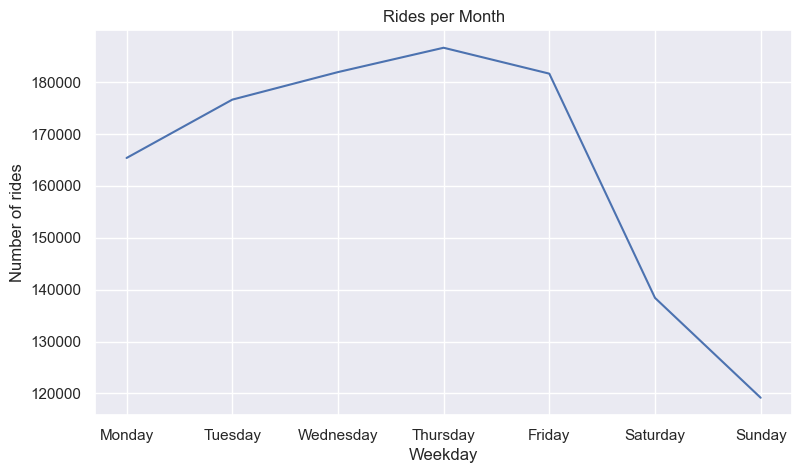

In [27]:
# Data
demand_weekday = df_boston.groupby(df_boston['start_time'].dt.day_name(), sort=True)
grouped_weekdays = demand_weekday.size().reindex(lh.days)

# Graph
ax = sns.lineplot(data=grouped_weekdays)
ax.set_xticks(grouped_weekdays.index)
ax.set(xlabel='Weekday', ylabel='Number of rides', title='Rides per Month')

## Share of rentals per weekday for every month
In addition to the graph above, we show in this graph the share of rentals for every weekday of the week grouped by the different months over the complete year.

[Text(0, 0.5, 'Percent of rentals of the week'), Text(0.5, 0, 'Weekdays')]

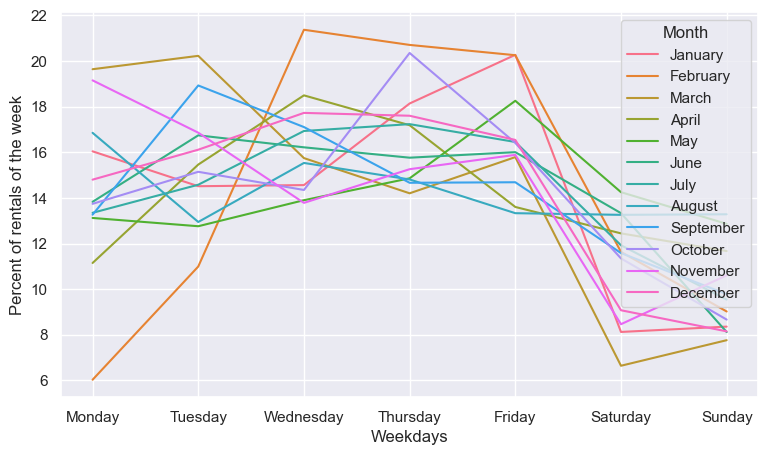

In [28]:
df_rentals_month_weekday = df_boston.copy()

# Add Column Month with the month of each ride
df_rentals_month_weekday['Month'] = df_rentals_month_weekday['start_time'].dt.month_name()

# Add Column Weekday with the weekday of each ride
df_rentals_month_weekday['Weekday'] = df_rentals_month_weekday['start_time'].dt.day_name()

# Group all rides of the year by Month and Weekday
df_rentals_month_weekday = df_rentals_month_weekday.groupby(['Month', 'Weekday']).size().reset_index(name='num_rides')

summ = df_rentals_month_weekday.groupby('Month')['num_rides'].sum()
df_rentals_month_weekday["percent"] = df_rentals_month_weekday.apply(
    lambda x: (x['num_rides'] / summ[x['Month']]) * 100, axis=1)

# Transform dtype from object to category
df_rentals_month_weekday.Weekday = pd.Categorical(df_rentals_month_weekday.Weekday, categories=lh.days)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Weekday')

# Transform dtype from object to category
df_rentals_month_weekday.Month = pd.Categorical(df_rentals_month_weekday.Month, categories=lh.months)
df_rentals_month_weekday = df_rentals_month_weekday.sort_values('Month')

ax = sns.lineplot(data=df_rentals_month_weekday, x='Weekday', y='percent', hue='Month')
ax.set(ylabel='Percent of rentals of the week', xlabel='Weekdays')

## Rental by UserType by month
Here we group the rentals by month and user type. The proportion is mostly subscriber 64%-70%, only in february is an exception where the share of subscriber increases to 77%.

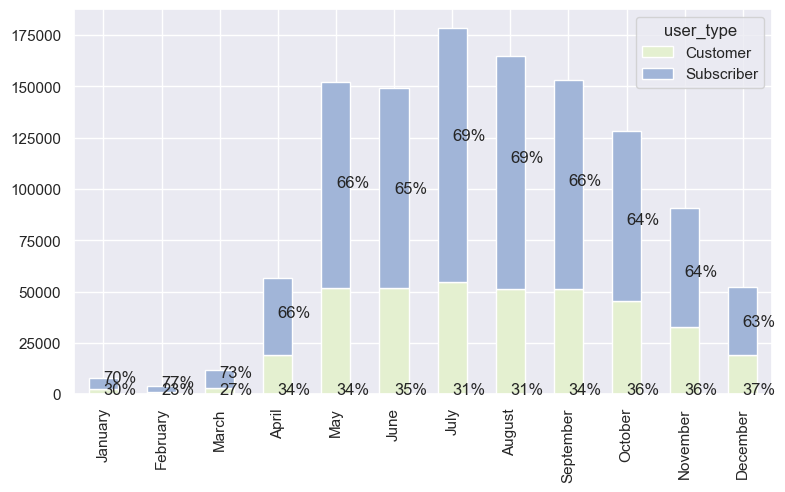

In [29]:
# The grouped pivot table is unstacked, so that every user_type gets a table in a dataframe
months_by_user_type = df_boston.groupby([df_boston["start_time"].dt.month, 'user_type']).size().unstack()
months_by_user_type.index = lh.months

months_by_user_type.plot(kind='bar', stacked=True, color={'Subscriber': '#A1B5D8', 'Customer': '#E4F0D0'})

for index, row in months_by_user_type.iterrows():
    part_sum = row['Customer'] + row['Subscriber']

    plt.text(x=lh.months.index(index), y=0, s=str(round(row['Customer'] / part_sum * 100)) + "%")
    plt.text(x=lh.months.index(index), y=row['Subscriber'], s=str(round(row['Subscriber'] / part_sum * 100)) + "%")

## Rental by Point of Day
In the two following graphs we divided the day into four parts, morning (6-11 oclock), afternoon (12 - 18 oclock), evening (19 - 23 oclock) and night (0 - 5 oclock). And compared the shares of all rentals for the point of day over all months. The proportions is evenly distributed, only in the winter months we can see, that the number of rentals in the evening is decreasing and in the mopring is increasing

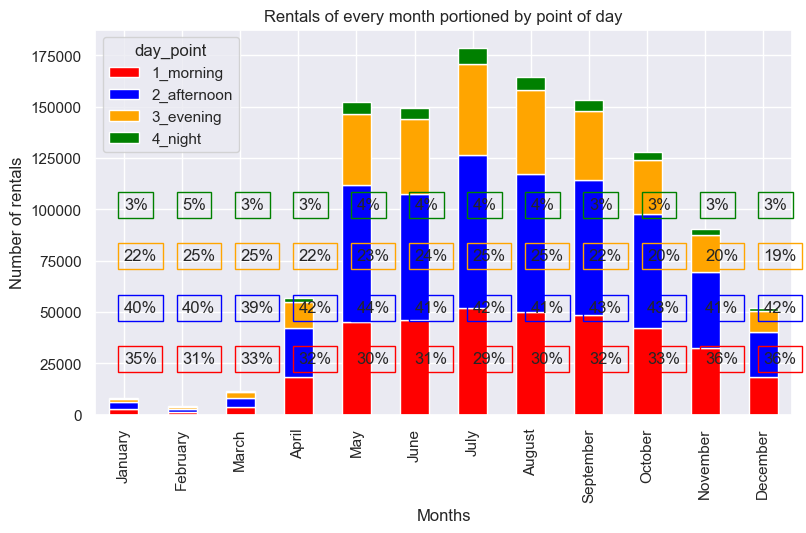

In [30]:
with_point_day = df_boston.copy()
with_point_day["day_point"] = with_point_day["start_time"].dt.hour.apply(lambda x: lh.get_point_of_day(x))

with_point_day = with_point_day.groupby([df_boston["start_time"].dt.month, 'day_point']).size().unstack()
with_point_day.index = lh.months

with_point_day.plot(kind='bar', stacked=True,
                    color={'1_morning': 'red', '2_afternoon': 'blue', '3_evening': 'orange', '4_night': 'green', })

# Graph props
plt.title("Rentals of every month portioned by point of day")
plt.xlabel("Months")
plt.ylabel("Number of rentals")

for index, row in with_point_day.iterrows():
    sum = row['1_morning'] + row['2_afternoon'] + row['3_evening'] + row['4_night']

    # The y values are constant, because the values in Febr. are so small, that the text would overlap when it's centered in the bars height
    plt.text(x=lh.months.index(index), y=25000, s=str(round(row['1_morning'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='red'))
    plt.text(x=lh.months.index(index), y=50000, s=str(round(row['2_afternoon'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='blue'))
    plt.text(x=lh.months.index(index), y=75000, s=str(round(row['3_evening'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='orange'))
    plt.text(x=lh.months.index(index), y=100000, s=str(round(row['4_night'] / sum * 100)) + "%",
             bbox=dict(facecolor='none', edgecolor='green'))

Text(0, 0.5, 'Share of rentals in %')

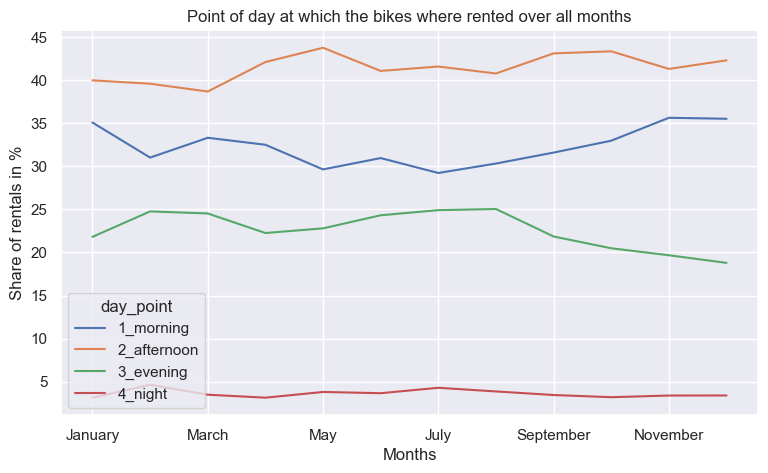

In [31]:
# For each value calculate the share by dividing the value by the sum of complete row
point_of_days_without_sum = with_point_day.loc[:, "1_morning":"4_night"].div(with_point_day.sum(axis=1), axis=0).mul(
    100)
point_of_days_without_sum.index = lh.months
point_of_days_without_sum.plot(kind='line')

# Graph props
plt.title("Point of day at which the bikes where rented over all months")
plt.xlabel("Months")
plt.ylabel("Share of rentals in %")

## Rentals by temperature level
We divide the average temperature into five different levels and look at the distribution of the rentals over the different levels

temperature
1_very_hot      66319
2_hot          176494
3_good         464504
4_cold         279464
5_very_cold     98543
dtype: int64


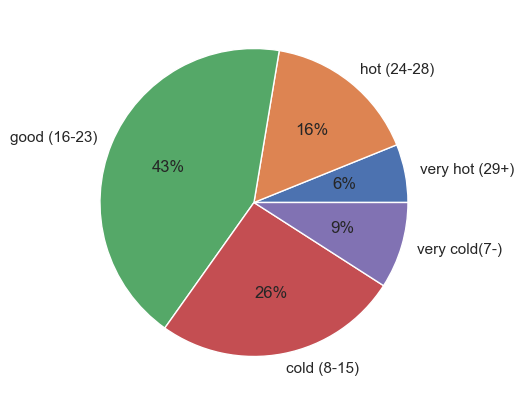

In [32]:
temperature_level = df_boston.copy()
temperature_level["temperature"] = df_boston.apply(
    lambda x: lh.get_level_of_temperature(lh.get_middle_of_two_numbers(x["min_temp"], x["max_temp"])), axis=1)

grouped_by_temperature = temperature_level.groupby(temperature_level["temperature"]).size()

print(grouped_by_temperature)

plt.pie(grouped_by_temperature.values, labels=lh.temperature_points, autopct='%.0f%%')
plt.show()

## Average Rentals/Day at every temperature level
We calculate the average number of rentals per day for every temperature level

In [33]:
grouped_by_temperature_an_date = temperature_level.groupby(
    [temperature_level["temperature"], temperature_level["start_time"].dt.weekday]).size()

# Build a table from group series in order to access the count of days per temperature and the average num of rentals
rentals_every_day_by_temperature = grouped_by_temperature_an_date.reset_index(name="rentals every weekday")
rentals_every_day_by_temperature = rentals_every_day_by_temperature.drop(columns=["start_time"])

# Group the rentals by temp and calculate the mean for all days of the temperature
average_rent_per_temperature_day = rentals_every_day_by_temperature.groupby(
    rentals_every_day_by_temperature["temperature"]).mean(numeric_only=True)

print(average_rent_per_temperature_day)

             rentals every weekday
temperature                       
1_very_hot             9474.142857
2_hot                 25213.428571
3_good                66357.714286
4_cold                39923.428571
5_very_cold           14077.571429


## Average Rentals/Hour at every temperature level
We calculate the average number of rentals per hour for every temperature level

In [34]:
grouped_by_temperature_an_hour = temperature_level.groupby(
    [temperature_level["temperature"], temperature_level["start_time"].dt.hour]).size()

# Build a table from group series in order to access the count of hours per temperature and the average num of rentals
rentals_every_hour_by_temperature = grouped_by_temperature_an_hour.reset_index(name='rentals every hour')
rentals_every_hour_by_temperature = rentals_every_hour_by_temperature.drop(columns=["start_time"])

# Group the rentals by temp and calculate the mean for all hours of the temperature
average_rent_per_temperature_hour = rentals_every_hour_by_temperature.groupby(
    rentals_every_hour_by_temperature["temperature"]).mean(numeric_only=True)

print(average_rent_per_temperature_hour)

             rentals every hour
temperature                    
1_very_hot          4421.266667
2_hot               7353.916667
3_good             19354.333333
4_cold             11644.333333
5_very_cold         4105.958333


## Rain impact on hourly demand
We want to examine what effect the rain has on the demand of the rentals. For this we thought of two different cases. In the first case it is not raining in the moment of the start of the rental, but it rained the hour before. The second case is the other way around. It is raining at the start of the rental, but it has not rained the hour before. We do the demand change calculation by shifting the hourly demand by one hour, so that we can directly compare the current demand with the demand an hour ago. We do the same for the precip to determine if it has rained the hour before.

In [35]:
df_demand = df_boston.resample(rule='H', on='start_time').size().reset_index(name='demand')
df_demand.columns = ['date_time', 'demand']

df_weather = pd.read_csv('./data/weather_hourly_boston.csv')
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%Y-%m-%d %X')
df_demand = df_demand.merge(df_weather, how='left', on='date_time')

df_demand['demand_h-1'] = df_demand['demand'].shift(periods=1)

# Remove first two lines because no trailing
df_demand = df_demand[2::]

# Remove all rows with demand 0.0, so that no division with 0 is calculated
df_demand = df_demand[df_demand['demand_h-1'] != 0.0]

# Calculate Demand Change
df_demand['demand_change_h-1'] = df_demand.apply(lambda x: x['demand'] / x['demand_h-1'],
                                                                             axis=1)

# Remove all lines with infinity to not break further plotting
df_demand = df_demand[df_demand['demand_change_h-1'] != math.inf]
df_demand['rain_hour_before'] = df_demand['precip'].shift(periods=1)
df_demand = df_demand[1::]

df_rain_demand_filtered = df_demand[
    df_demand.apply(lambda x: (x["rain_hour_before"] == 1.0 and x["precip"] == 0.0), axis=1)]
df_not_rain_demand_filtered = df_demand[
    df_demand.apply(lambda x: (x["rain_hour_before"] == 0.0 and x["precip"] == 1.0), axis=1)]

print(df_rain_demand_filtered["demand_change_h-1"].mean())
print(df_not_rain_demand_filtered["demand_change_h-1"].mean())

1.3009314233163625
1.1551372540732485


### Case 1: Currently not raining, it rained the hour before
A 30.1% increase of rentals: Possible explanation, people see that it stopped raining and start rental.

###

### Case 2: Currently raining, it did not rain the hour before
A 15.5% increase of rentals: Possible explanation, people see that it was dry, start rental and then it starts raining.

In [36]:
df_demand['daytime'] = df_demand["date_time"].apply(lambda x: lh.get_pnt_day_with_pnt_week(x))
df_demand = pd.get_dummies(df_demand, columns=['daytime'])

## Measure of correlation
With the previous calculation we have shown, that the precip has an effect on the demand change. Now we want to examine how strong this effect is. We use the eta squared coefficient as a measure of correlation. This is because we have the metric variable 'demand_change' and the nominal variable 'precip'. The eta squared coefficient measures the extent to which the total variance of the dependent metric variable 'demand_change' is explained by the independent nominal variable 'precip'.

In [37]:
pg.compute_effsize(df_demand['precip'], df_demand['demand_change_h-1'], eftype='eta-square')

0.19513618211546674

### How to interpret the eta coefficient:
.01: Small effect size
.06: Medium effect size
.14 or higher: Large effect size

Because of eta-coefficient of 0.19 we large dependency between the demand change and the precip